# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_5400.csv')
df.head(10)

,content,sentimen
0,bogor keluarga fw 22 perempuan dibunuh pacarny...,negatif
1,khoiri 52 warga dusun blimbing desa parerejo k...,negatif
2,polisi menangkap andrea cw inggris chansler am...,negatif
3,wakil ketua umum pan yandri susanto capres ani...,negatif
4,pria medan satria kota bekasi terluka lehernya...,negatif
5,kpu ri menilai surat suara taipei taiwan surat...,negatif
6,jet jet tempur israel melancarkan serangan uda...,negatif
7,rumah milik mf 16 remaja diduga mencekik bocah...,negatif
8,calon presiden ganjar pranowo relawannya ikuta...,negatif
9,calon wakil presiden cawapres nomor urut 1 muh...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 245316
Jumlah fitur Bag of Words: 26266
Jumlah fitur gabungan: 271582


### Model Naiye Bayes

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Tanpa Parameter

In [11]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(model_naiye_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [14]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 77.96%
F1 Score: 77.72%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.81      0.70      0.75       575
      netral       0.82      0.72      0.77       508
     positif       0.73      0.92      0.82       537

    accuracy                           0.78      1620
   macro avg       0.79      0.78      0.78      1620
weighted avg       0.79      0.78      0.78      1620

Confusion Matrix:
 [[401  58 116]
 [ 76 368  64]
 [ 21  22 494]]


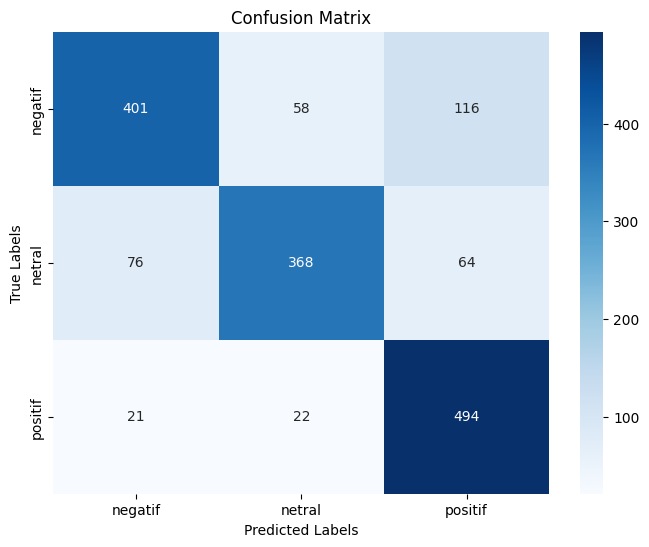

In [15]:
# Plot confusion matrix
plot_confusion_matrix(tfidf_matrix, label_encoder.classes_)

In [18]:
test = ('Jeka Saragih On Fire Menatap Debut di UFC')
line = tfidf_vectorizer.transform([test])
line.shape
test_result = model_naiye_tanpa_parameter.predict(line)
predicted_label = label_encoder.inverse_transform(test_result)
print("Hasil Prediksi:", predicted_label)

Hasil Prediksi: ['netral']


#### Tuning

In [16]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid = {
#     'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Parameter alpha untuk smoothing
#     'fit_prior': [True, False]            # Opsional, apakah akan mempelajari probabilitas prior atau tidak
# }

# # Buat objek GridSearchCV
# grid_search = GridSearchCV(model_naiye_tanpa_parameter, param_grid, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Evaluasi model dengan parameter terbaik
# best_model = grid_search.best_estimator_
# accuracy, f1, _, _ = train_and_evaluate(best_model, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)
# print("Best Parameters:", best_model)
# print("Accuracy (Best Model):", accuracy)
# print("F1 Score (Best Model):", f1)

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Score: 0.7984126984126985
Best Parameters: MultinomialNB(alpha=0.1)
Accuracy (Best Model): 79.75308641975309
F1 Score (Best Model): 79.59697593897329


#### Pakai Paramater

In [20]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha=0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(model_naiye_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [21]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 79.75%
F1 Score: 79.60%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.82      0.74      0.78       575
      netral       0.83      0.74      0.78       508
     positif       0.76      0.91      0.83       537

    accuracy                           0.80      1620
   macro avg       0.80      0.80      0.80      1620
weighted avg       0.80      0.80      0.80      1620

Confusion Matrix:
 [[426  54  95]
 [ 70 377  61]
 [ 25  23 489]]


### Model SVM

In [23]:
from sklearn.svm import SVC

#### Tanpa Paramater

In [24]:
# Initialize Naive Bayes classifier
svm_tanpa_parameter = SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(svm_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [25]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 87.16%
F1 Score: 87.13%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.86      0.85      0.85       575
      netral       0.89      0.84      0.86       508
     positif       0.87      0.93      0.90       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[489  34  52]
 [ 59 426  23]
 [ 23  17 497]]


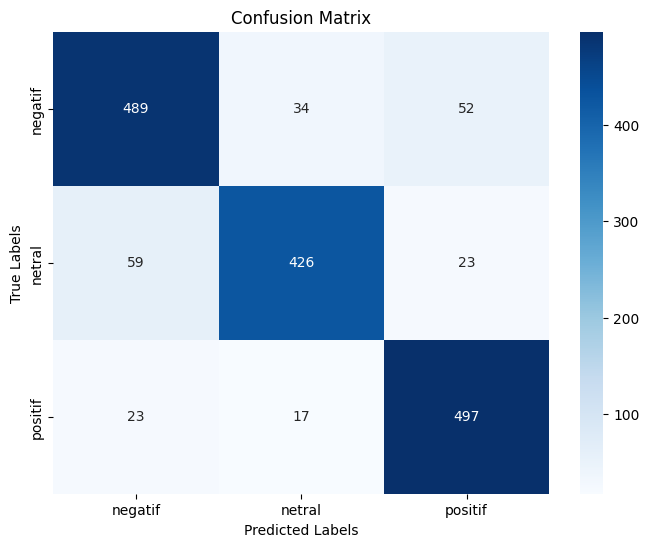

In [26]:
# Plot confusion matrix
plot_confusion_matrix(tfidf_matrix, label_encoder.classes_)

#### Tuning

In [27]:
# # Tentukan parameter grid yang akan dieksplorasi
# svm_param_grid = {
#     'C': [0.1, 1, 10, 100],            # Parameter regulasi (cost)
#     'kernel': ['linear', 'rbf'],       # Kernel yang digunakan
#     'gamma': ['scale', 'auto'],        # Koefisien kernel untuk 'rbf'
# }

# # Buat objek GridSearchCV
# svm_grid_search = GridSearchCV(svm_tanpa_parameter, svm_param_grid, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# svm_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# svm_best_params = svm_grid_search.best_params_
# svm_best_score = svm_grid_search.best_score_

# print("Best Parameters:", svm_best_params)
# print("Best Score:", svm_best_score)

# # Evaluasi model dengan parameter terbaik
# svm_best_model = svm_grid_search.best_estimator_
# svm_accuracy, svm_f1, _, _ = train_and_evaluate(svm_best_model, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# print("Best Parameters:", svm_best_model)
# print("Accuracy (Best Model):", svm_accuracy)
# print("F1 Score (Best Model):", svm_f1)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.8661375661375661
Best Parameters: SVC(C=10, kernel='linear', random_state=42)
Accuracy (Best Model): 87.4074074074074
F1 Score (Best Model): 87.37759517771214


#### Pakai Parameter

In [28]:
# Initialize Naive Bayes classifier
svm_parameter = SVC(C=10,gamma='scale',kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(svm_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [29]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 87.41%
F1 Score: 87.38%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.86      0.86      0.86       575
      netral       0.90      0.84      0.87       508
     positif       0.87      0.92      0.89       537

    accuracy                           0.87      1620
   macro avg       0.88      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[492  33  50]
 [ 54 428  26]
 [ 24  17 496]]


### Model Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Paramater

In [31]:
# Initialize Naive Bayes classifier
lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(lr_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [33]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 83.33%
F1 Score: 83.24%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.82      0.79      0.80       575
      netral       0.88      0.79      0.83       508
     positif       0.81      0.92      0.86       537

    accuracy                           0.83      1620
   macro avg       0.84      0.83      0.83      1620
weighted avg       0.84      0.83      0.83      1620

Confusion Matrix:
 [[453  39  83]
 [ 76 401  31]
 [ 23  18 496]]


#### Tuning

In [34]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid_logistic = {
#     'C': [0.1, 0.5, 1.0, 2.0, 5.0],   # Invers dari kekuatan regularisasi
#     'penalty': ['l1', 'l2'],           # Jenis regularisasi: Lasso (l1) atau Ridge (l2)
#     'solver': ['liblinear', 'saga'],  # Algoritma solver: liblinear atau saga (cocok untuk regularisasi L1)
#     'max_iter': [1000]        # Jumlah iterasi maksimum
# }

# # Buat objek GridSearchCV untuk Logistic Regression
# logistic_grid_search = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# logistic_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params_logistic = logistic_grid_search.best_params_
# best_score_logistic = logistic_grid_search.best_score_

# print("Best Parameters (Logistic Regression):", best_params_logistic)
# print("Best Score (Logistic Regression):", best_score_logistic)

# # Evaluasi model Logistic Regression dengan parameter terbaik
# best_model_logistic = logistic_grid_search.best_estimator_
# accuracy_logistic, f1_logistic, _, _ = train_and_evaluate(best_model_logistic, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)
# print("Best Parameters:", best_model_logistic)
# print("Accuracy (Best Model - Logistic Regression):", accuracy_logistic)
# print("F1 Score (Best Model - Logistic Regression):", f1_logistic)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters (Logistic Regression): {'C': 5.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score (Logistic Regression): 0.8513227513227513
Best Parameters: LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')
Accuracy (Best Model - Logistic Regression): 86.72839506172839
F1 Score (Best Model - Logistic Regression): 86.69678513829533


#### Parameter

In [35]:
# Initialize Naive Bayes classifier
lr_parameter = LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(lr_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [36]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 86.73%
F1 Score: 86.70%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.86      0.85      0.85       575
      netral       0.88      0.83      0.86       508
     positif       0.86      0.92      0.89       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[489  37  49]
 [ 56 424  28]
 [ 26  19 492]]


### Model Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Paramater

In [38]:
# Initialize Naive Bayes classifier
rfc_tanpa_parameter = RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(rfc_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [39]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 82.96%
F1 Score: 82.67%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.89      0.69      0.78       575
      netral       0.81      0.92      0.86       508
     positif       0.81      0.90      0.85       537

    accuracy                           0.83      1620
   macro avg       0.83      0.83      0.83      1620
weighted avg       0.84      0.83      0.83      1620

Confusion Matrix:
 [[398  74 103]
 [ 31 465  12]
 [ 18  38 481]]


#### Tuning

In [40]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid_random_forest = {
#     'n_estimators': [50, 100, 200],      # Jumlah pohon keputusan dalam model
#     'max_depth': [None, 10, 20, 30],      # Maksimum kedalaman setiap pohon keputusan
#     'min_samples_split': [2, 5, 10],      # Jumlah sampel minimum yang dibutuhkan untuk membagi node internal
#     'min_samples_leaf': [1, 2, 4]         # Jumlah sampel minimum yang dibutuhkan untuk menjadi leaf node
# }

# # Buat objek GridSearchCV untuk RandomForestClassifier
# random_forest_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_random_forest, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# random_forest_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params_random_forest = random_forest_grid_search.best_params_
# best_score_random_forest = random_forest_grid_search.best_score_

# print("Best Parameters (Random Forest):", best_params_random_forest)
# print("Best Score (Random Forest):", best_score_random_forest)

# # Evaluasi model RandomForestClassifier dengan parameter terbaik
# best_model_random_forest = random_forest_grid_search.best_estimator_
# accuracy_random_forest, f1_random_forest, _, _ = train_and_evaluate(best_model_random_forest, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# print("Best Parameters:",best_model_random_forest)
# print("Accuracy (Best Model - Random Forest):", accuracy_random_forest)
# print("F1 Score (Best Model - Random Forest):", f1_random_forest)

Best Parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (Random Forest): 0.8240740740740741
Best Parameters: RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)
Accuracy (Best Model - Random Forest): 83.0246913580247
F1 Score (Best Model - Random Forest): 82.77567772110962


#### Paramater

In [41]:
# Initialize Naive Bayes classifier
rfc_parameter = RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,n_estimators=200)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(rfc_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [42]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 82.65%
F1 Score: 82.37%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.87      0.69      0.77       575
      netral       0.83      0.89      0.86       508
     positif       0.79      0.91      0.85       537

    accuracy                           0.83      1620
   macro avg       0.83      0.83      0.83      1620
weighted avg       0.83      0.83      0.82      1620

Confusion Matrix:
 [[399  59 117]
 [ 46 452  10]
 [ 14  35 488]]


### Model Ensemble Learning

In [43]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = svm_parameter
best_model_random_forest = rfc_parameter
best_model_logistic_regression = lr_parameter

In [44]:
from sklearn.ensemble import VotingClassifier

#### Model Gabungin 4 Model

In [45]:
# Membuat model ensemble
ensemble_model_4 = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_4, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [46]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 86.85%
F1 Score: 86.84%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.85      0.85      0.85       575
      netral       0.88      0.85      0.87       508
     positif       0.88      0.91      0.89       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[487  35  53]
 [ 59 433  16]
 [ 28  22 487]]


#### Model 3 dengan Akurasi Terbaik

In [47]:
# Membuat model ensemble
ensemble_model_3 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_3, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [48]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 87.41%
F1 Score: 87.36%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.87      0.83      0.85       575
      netral       0.89      0.86      0.88       508
     positif       0.87      0.93      0.90       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[479  38  58]
 [ 51 438  19]
 [ 23  15 499]]


#### Model 2 Dengan Nilai Akurasi Terbaik 

In [49]:
# Membuat model ensemble
ensemble_model_2 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_2, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [50]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 87.47%
F1 Score: 87.48%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.83      0.90      0.86       575
      netral       0.89      0.83      0.86       508
     positif       0.91      0.89      0.90       537

    accuracy                           0.87      1620
   macro avg       0.88      0.87      0.87      1620
weighted avg       0.88      0.87      0.87      1620

Confusion Matrix:
 [[515  26  34]
 [ 69 424  15]
 [ 34  25 478]]
